In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

 ## Exploratory Climate Analysis

In [8]:
first_row = session.query(Measurement).first()
first_row.__dict__
# for row in session.query(Measurement.date,Measurement.prcp).limit(10):
#     print (row)


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x129077316d8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [9]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1290773e2e8>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168}

In [10]:
# To get the latest date in the dataset
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

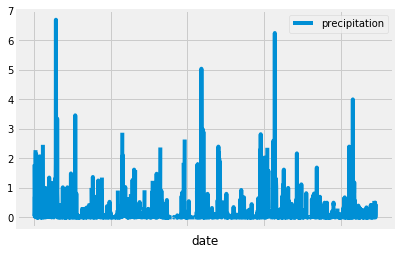

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days =365)
# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp).\
             filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result, columns=['date','precipitation'])
df = df.set_index('date')
df.head()
df= df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
stations

9

In [14]:
# Query to find the most active station, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of station?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs),
       func.count(Measurement.tobs)]

temp_data = session.query(*sel).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
temp_data
# df2 = pd.DataFrame(temp_data, columns=['station_id','tmin','tmax','tavg','tobs_count'])
# df2


[('USC00519281', 54.0, 85.0, 71.66378066378067, 2772),
 ('USC00519397', 56.0, 87.0, 74.55323054331865, 2724),
 ('USC00513117', 59.0, 85.0, 72.68918420081211, 2709),
 ('USC00519523', 56.0, 85.0, 74.5436493068565, 2669),
 ('USC00516128', 58.0, 84.0, 70.91500765696784, 2612),
 ('USC00514830', 58.0, 85.0, 74.8732970027248, 2202),
 ('USC00511918', 53.0, 87.0, 71.61596766043456, 1979),
 ('USC00517948', 58.0, 87.0, 74.68440233236151, 1372),
 ('USC00518838', 58.0, 83.0, 72.72407045009784, 511)]

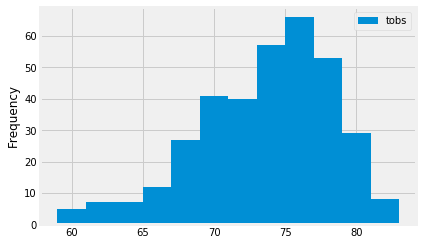

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.tobs).\
                  filter(Measurement.station == 'USC00519281' ).\
                  filter(Measurement.date >= year_ago).all()
most_active_station
df3=pd.DataFrame(most_active_station, columns=['tobs'])
df3.plot.hist(bins=12)
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
t_data = calc_temps('2017-04-01', '2017-04-08')
t_data


[(67.0, 74.68, 80.0)]

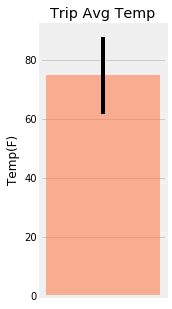

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
t_avg = t_data[0][1]
yerror = t_data[0][2] - t_data[0][0]
plt.figure(figsize=(2,5))
plt.bar(0, t_avg, color='coral', alpha=0.6, yerr=yerror)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylabel("Temp(F)")
plt.show()